In [1]:
# load -> clean -> features -> fit/validate -> predict -> submit
from linear_model_base import RidgeRegression
import numpy as np

In [2]:
from data_cleaner import Data_Cleaner

#80/20 train test split to verify predictions before upload

data_cleaner_train = Data_Cleaner("C:/Users/Tim/Documents/GitHub/MLProject1/project1/data/train.csv")
data_cleaner_train.tX = data_cleaner_train.tX[:200000,:]
data_cleaner_train.y = data_cleaner_train.y[:200000]

#replace with 1, due to log scaling 
data_cleaner_train._fill_with_NaN()
data_cleaner_train.replace_with_one()

data_cleaner_test = Data_Cleaner("C:/Users/Tim/Documents/GitHub/MLProject1/project1/data/train.csv")
data_cleaner_test.tX = data_cleaner_test.tX[200000:,:]
data_cleaner_test.y = data_cleaner_test.y[200000:]

data_cleaner_test._fill_with_NaN()
data_cleaner_test.replace_with_one()

In [3]:
def build_interactions(x):
    x_out = np.array(x)
    for i in range(int(x.shape[1])):
        x_i = x[:,0]
        x = np.delete(x, 0, 1)
        x_interact = (x_i*x.T).T
        
        x_out = np.hstack([x_out,x_interact])
        
    return x_out


def build_poly(x, degree, add_degree_zero=False):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # polynomial basis function: TODO
    # this function should return the matrix formed
    # by applying the polynomial basis to the input data
    if add_degree_zero:
        xN = np.hstack([np.ones([x.shape[0],1]),x])
    else:
        xN = x
    if degree>0:
        for i in range(degree-1):
            xN = np.hstack([xN, x**(i+2)])
    return np.array(xN)

In [4]:
#find columns with multiscale input (max greater than 100)
log_columns = np.max(data_cleaner_train.tX, axis=0)>100
#log(x+1) of columns with multiscale data, to ensure no x <= 0
data_cleaner_train.tX[:,log_columns] = np.log(data_cleaner_train.tX[:,log_columns]+1)

In [5]:
#generate poly features and interaction features
data_cleaner_train.tX = build_poly(data_cleaner_train.tX,2)
data_cleaner_train.tX = build_interactions(data_cleaner_train.tX)

In [6]:
#normalise train features
minimum, maximum = data_cleaner_train.getMinMax()
data_cleaner_train.standardize()

In [7]:
from linear_model_base import RidgeRegression
import numpy as np 

Model = RidgeRegression(data_cleaner_train)
search_space = np.logspace(-15, -5, 15)
    
rmse_te = []
rmse_tr = []

for lambda_ in search_space:
        
    tr, te = Model.cross_validation(5, lambda_=lambda_)
    rmse_te.append(te)
    rmse_tr.append(tr)
        
    print("lambda {}".format(lambda_))  

lambda 1e-15
lambda 5.179474679231202e-15
lambda 2.6826957952797274e-14
lambda 1.389495494373136e-13
lambda 7.196856730011528e-13
lambda 3.727593720314938e-12
lambda 1.9306977288832457e-11
lambda 1e-10
lambda 5.179474679231223e-10
lambda 2.6826957952797275e-09
lambda 1.3894954943731388e-08
lambda 7.196856730011529e-08
lambda 3.727593720314938e-07
lambda 1.9306977288832536e-06
lambda 1e-05


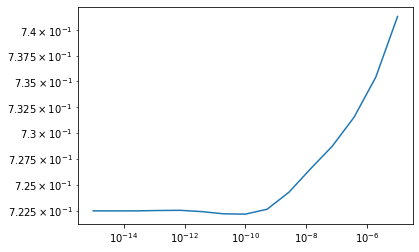

In [8]:
import matplotlib.pyplot as plt
plt.loglog(np.logspace(-15, -5, 15),rmse_te)

In [9]:
best_lambda = search_space[np.where(rmse_te==np.min(rmse_te))]
np.min(rmse_te)

0.7221538216836288

In [10]:
weights = Model._run(lambda_ = best_lambda)

In [11]:
from proj1_helpers import *
#generate poly features and standardise according to min_max from training
data_cleaner_test.tX[:,log_columns] = np.log(data_cleaner_test.tX[:,log_columns]+1)
data_cleaner_test.tX = build_poly(data_cleaner_test.tX,2)
data_cleaner_test.tX = build_interactions(data_cleaner_test.tX )
data_cleaner_test.tX = (data_cleaner_test.tX - minimum) / (maximum - minimum)

In [12]:
Model = RidgeRegression(data_cleaner_test)
weights = Model._run(lambda_ = best_lambda)

y_pred = predict_labels(weights, data_cleaner_test.tX)

In [14]:
#estimate accuracy based on test set
def estimate_Leaderboard_score(y_true,weights,data):
    """Helper function estimating the categorical accuracy on the leaderscore
    """
    y_pred = predict_labels(weights, data)
    N_tot = y_pred.shape[0]
    N_true = len(np.where(y_pred == y_true)[0])
    categorical_acuracy = N_true/N_tot
    return categorical_acuracy

estimate_Leaderboard_score(data_cleaner_test.y, weights, data_cleaner_test.tX)

0.83314

In [14]:
#generate predictions
data_cleaner_upload = Data_Cleaner("C:/Users/Tim/Documents/GitHub/MLProject1/project1/data/test.csv")
data_cleaner_upload._fill_with_NaN()
data_cleaner_upload.replace_with_one()
data_cleaner_upload.tX[:,log_columns] = np.log(data_cleaner_upload.tX[:,log_columns]+1)
data_cleaner_upload.tX = build_poly(data_cleaner_upload.tX,2)
data_cleaner_upload.tX = build_interactions(data_cleaner_upload.tX)
data_cleaner_upload.tX = (data_cleaner_upload.tX - minimum) / (maximum - minimum)

y_pred = predict_labels(weights, data_cleaner_upload.tX)
#create_csv_submission(data_cleaner_upload.ids, y_pred, "C:/Users/Tim/Documents/GitHub/MLProject1/project1/data/poly2interactionslogRidge.csv")

In [16]:
data_cleaner_upload.tX.shape

array([-1., -1., -1., ...,  1., -1., -1.])